# 03 - Modelado y Análisis Predictivo
## Proyecto Final: Análisis de Datos
### Objetivo: Desarrollar modelos para predecir retrasos y renovaciones

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [54]:
# Cargar datos
data_path = "../data/"
clients = pd.read_csv(os.path.join(data_path, "clients_curated.csv"))
projects = pd.read_csv(os.path.join(data_path, "projects_curated.csv"))

# Unir datasets
df = projects.merge(clients, on='client_id', how='left')
print(f"Dataset combinado: {df.shape}")
df.head(3)

Dataset combinado: (200, 20)


,project_id,client_id,start_date,planned_end_date,actual_end_date,budget_usd,dev_team_size,complexity,status,final_cost_usd,duration_planned,duration_actual,industry,size,region,support_contract,tickets_opened_last_year,avg_response_time_hours,satisfaction_score,renewed_contract
0,P2000,C1050,2024-01-15,2024-04-03,2024-03-27,27811.31,4,Media,On-time,27496.80,79,72,Otros,Grande,Oruro,1,25,12.8,1,1
1,P2001,C1057,2023-11-08,2024-04-16,2024-08-07,15455.14,5,Media,Delayed,17813.71,160,273,Retail,Mediana,Oruro,1,18,27.7,1,1
2,P2002,C1004,2024-10-01,2025-01-31,2025-01-25,26634.78,11,Baja,On-time,27121.70,122,116,Retail,Grande,Oruro,0,26,18.4,5,1


## Preprocesamiento

In [55]:
# Crear variable objetivo para proyectos (retraso)
df['is_delayed'] = (df['status'] == 'Delayed').astype(int)

# Features para modelo de retraso
features_delay = ['budget_usd', 'dev_team_size', 'complexity', 
                 'industry', 'size', 'satisfaction_score']

X_delay = df[features_delay].copy()
y_delay = df['is_delayed']

# Features para modelo de renovación
features_renewal = ['industry', 'size', 'satisfaction_score', 
                   'tickets_opened_last_year', 'avg_response_time_hours']

X_renewal = clients[features_renewal].copy()
y_renewal = clients['renewed_contract']

print("Variables objetivo creadas:")
print(f"Retrasos: {y_delay.value_counts().to_dict()}")
print(f"Renovaciones: {y_renewal.value_counts().to_dict()}")

Variables objetivo creadas:
Retrasos: {0: 135, 1: 65}
Renovaciones: {0: 62, 1: 38}


In [56]:
# Preprocesamiento: Encoding y escalado
def preprocess_features(X):
    X_processed = X.copy()
    
    # Encoding de variables categóricas
    categorical_cols = X_processed.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    
    # Escalado de variables numéricas
    numeric_cols = X_processed.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X_processed[numeric_cols] = scaler.fit_transform(X_processed[numeric_cols])
    
    return X_processed

X_delay_processed = preprocess_features(X_delay)
X_renewal_processed = preprocess_features(X_renewal)

print("Preprocesamiento completado")
print(f"Features retraso: {X_delay_processed.shape}")
print(f"Features renovación: {X_renewal_processed.shape}")

Preprocesamiento completado
Features retraso: (200, 6)
Features renovación: (100, 5)


In [57]:
# División train-test
X_delay_train, X_delay_test, y_delay_train, y_delay_test = train_test_split(
    X_delay_processed, y_delay, test_size=0.3, random_state=42, stratify=y_delay)

X_renewal_train, X_renewal_test, y_renewal_train, y_renewal_test = train_test_split(
    X_renewal_processed, y_renewal, test_size=0.3, random_state=42, stratify=y_renewal)

print("División train-test completada")
print(f"Retrasos - Train: {X_delay_train.shape}, Test: {X_delay_test.shape}")
print(f"Renovaciones - Train: {X_renewal_train.shape}, Test: {X_renewal_test.shape}")

División train-test completada
Retrasos - Train: (140, 6), Test: (60, 6)
Renovaciones - Train: (70, 5), Test: (30, 5)


## Modelo 1: Predicción de Retrasos en Proyectos

In [58]:
# Modelo simple: Regresión Logística
lr_delay = LogisticRegression(random_state=42)
lr_delay.fit(X_delay_train, y_delay_train)

# Modelo complejo: Random Forest
rf_delay = RandomForestClassifier(n_estimators=100, random_state=42)
rf_delay.fit(X_delay_train, y_delay_train)

print("Modelos de retraso entrenados")

Modelos de retraso entrenados


In [59]:
# Evaluación modelo de retrasos
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()
    
    return accuracy, f1, roc_auc

EVALUACIÓN DE MODELOS DE RETRASO
=== Regresión Logística (Retrasos) ===
Accuracy: 0.6833
F1-Score: 0.0000
ROC-AUC: 0.4429

Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        41
           1       0.00      0.00      0.00        19

    accuracy                           0.68        60
   macro avg       0.34      0.50      0.41        60
weighted avg       0.47      0.68      0.55        60



/home/sebas/Documents/Proyecto_final_Analisis_de_Datos/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sebas/Documents/Proyecto_final_Analisis_de_Datos/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sebas/Documents/Proyecto_final_Analisis_de_Datos/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

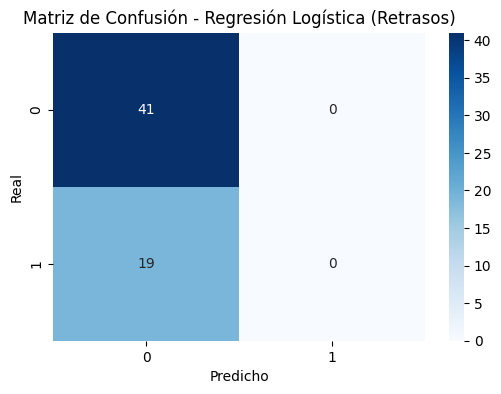

=== Random Forest (Retrasos) ===
Accuracy: 0.6500
F1-Score: 0.0870
ROC-AUC: 0.4255

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.93      0.78        41
           1       0.25      0.05      0.09        19

    accuracy                           0.65        60
   macro avg       0.46      0.49      0.44        60
weighted avg       0.54      0.65      0.56        60



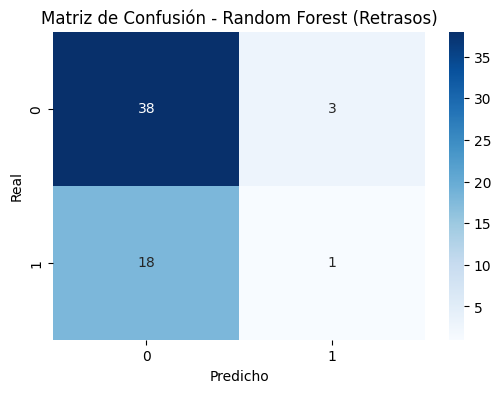

In [60]:
# Evaluar modelos de retraso
print("EVALUACIÓN DE MODELOS DE RETRASO")
print("="*50)
lr_delay_metrics = evaluate_model(lr_delay, X_delay_test, y_delay_test, "Regresión Logística (Retrasos)")
rf_delay_metrics = evaluate_model(rf_delay, X_delay_test, y_delay_test, "Random Forest (Retrasos)")

## Modelo 2: Predicción de Renovación de Contratos

In [61]:
# Modelo simple: Regresión Logística
lr_renewal = LogisticRegression(random_state=42)
lr_renewal.fit(X_renewal_train, y_renewal_train)

# Modelo complejo: Random Forest
rf_renewal = RandomForestClassifier(n_estimators=100, random_state=42)
rf_renewal.fit(X_renewal_train, y_renewal_train)

print("Modelos de renovación entrenados")

Modelos de renovación entrenados


EVALUACIÓN DE MODELOS DE RENOVACIÓN
=== Regresión Logística (Renovación) ===
Accuracy: 0.6333
F1-Score: 0.4211
ROC-AUC: 0.5981

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        19
           1       0.50      0.36      0.42        11

    accuracy                           0.63        30
   macro avg       0.59      0.58      0.58        30
weighted avg       0.62      0.63      0.62        30



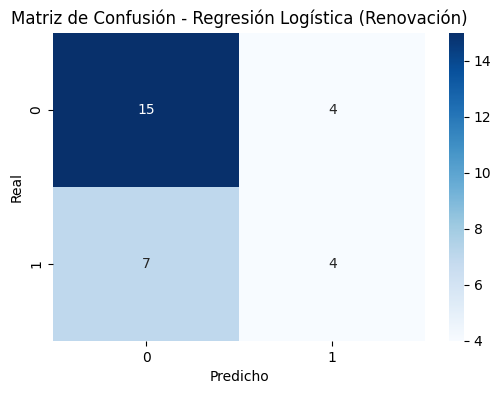

=== Random Forest (Renovación) ===
Accuracy: 0.5000
F1-Score: 0.3478
ROC-AUC: 0.5335

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.58      0.59        19
           1       0.33      0.36      0.35        11

    accuracy                           0.50        30
   macro avg       0.47      0.47      0.47        30
weighted avg       0.51      0.50      0.50        30



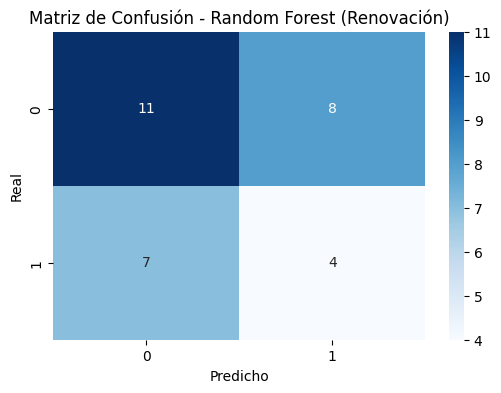

In [62]:
# Evaluar modelos de renovación
print("EVALUACIÓN DE MODELOS DE RENOVACIÓN")
print("="*50)
lr_renewal_metrics = evaluate_model(lr_renewal, X_renewal_test, y_renewal_test, "Regresión Logística (Renovación)")
rf_renewal_metrics = evaluate_model(rf_renewal, X_renewal_test, y_renewal_test, "Random Forest (Renovación)")

## Análisis de Importancia de Features

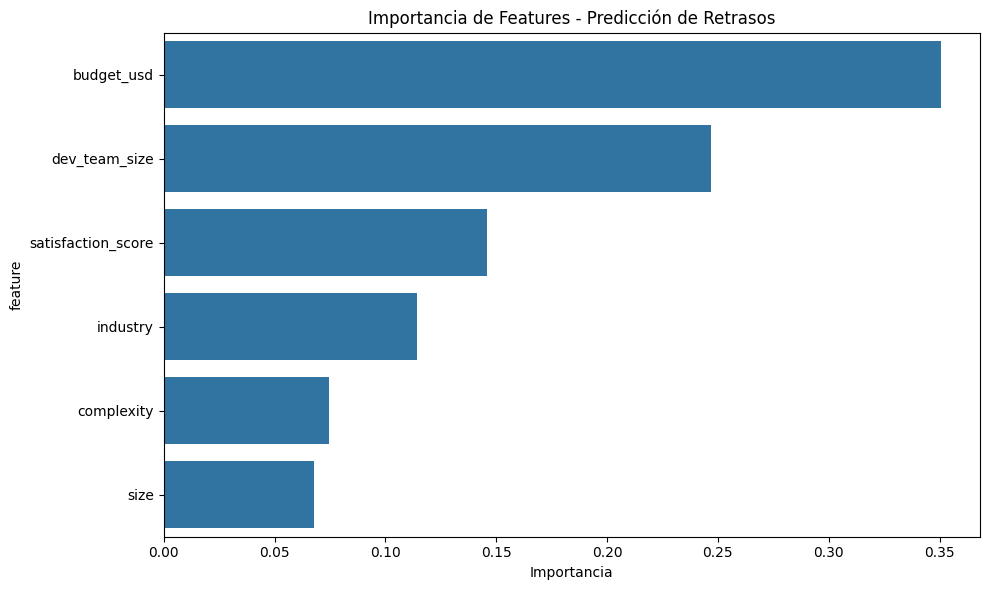

Importancia de features para retrasos:


,feature,importance
0,budget_usd,0.350677
1,dev_team_size,0.246739
5,satisfaction_score,0.145648
3,industry,0.114407
2,complexity,0.074792
4,size,0.067737


In [63]:
# Importancia de features para Random Forest (retrasos)
feature_importance_delay = pd.DataFrame({
    'feature': X_delay_processed.columns,
    'importance': rf_delay.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_delay)
plt.title('Importancia de Features - Predicción de Retrasos')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

print("Importancia de features para retrasos:")
feature_importance_delay

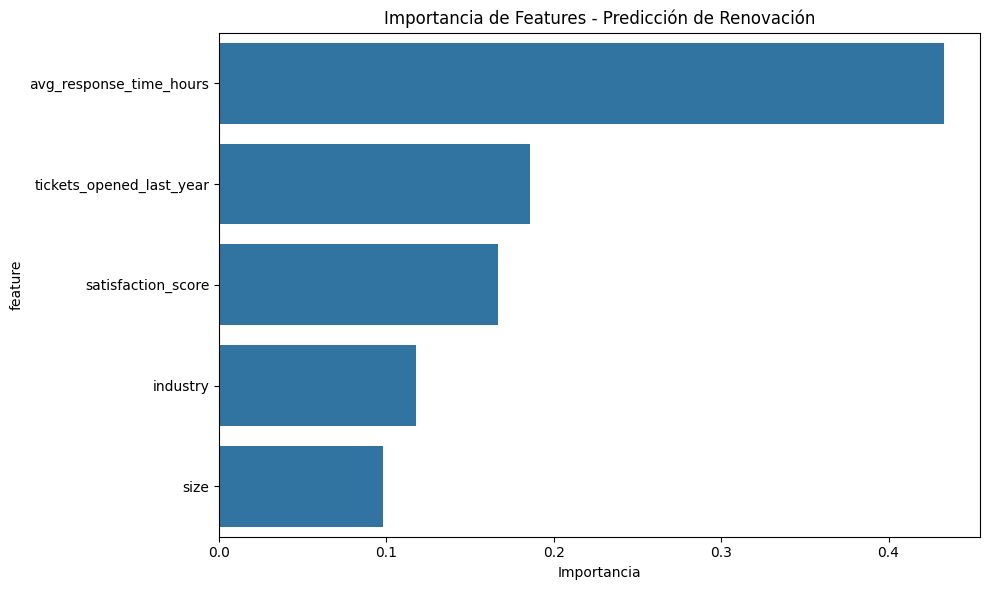

Importancia de features para renovación:


,feature,importance
4,avg_response_time_hours,0.433010
3,tickets_opened_last_year,0.185469
2,satisfaction_score,0.166496
0,industry,0.117400
1,size,0.097626


In [64]:
# Importancia de features para Random Forest (renovación)
feature_importance_renewal = pd.DataFrame({
    'feature': X_renewal_processed.columns,
    'importance': rf_renewal.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_renewal)
plt.title('Importancia de Features - Predicción de Renovación')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

print("Importancia de features para renovación:")
feature_importance_renewal

In [65]:
# Resumen comparativo de modelos
metrics_summary = pd.DataFrame({
    'Modelo': ['LR Retrasos', 'RF Retrasos', 'LR Renovación', 'RF Renovación'],
    'Accuracy': [lr_delay_metrics[0], rf_delay_metrics[0], lr_renewal_metrics[0], rf_renewal_metrics[0]],
    'F1-Score': [lr_delay_metrics[1], rf_delay_metrics[1], lr_renewal_metrics[1], rf_renewal_metrics[1]],
    'ROC-AUC': [lr_delay_metrics[2], rf_delay_metrics[2], lr_renewal_metrics[2], rf_renewal_metrics[2]]
})

print("=== RESUMEN DE MÉTRICAS ===")
print(metrics_summary)

print("Modelado completado")

=== RESUMEN DE MÉTRICAS ===
          Modelo  Accuracy  F1-Score   ROC-AUC
0    LR Retrasos  0.683333  0.000000  0.442875
1    RF Retrasos  0.650000  0.086957  0.425546
2  LR Renovación  0.633333  0.421053  0.598086
3  RF Renovación  0.500000  0.347826  0.533493
Modelado completado
